In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the VeloCityX dataset
data = pd.read_csv("2025-VeloCityX-Expanded-Fan-Engagement-Data.csv")

# Data Cleaning and Preprocessing
data.dropna(inplace=True)
data = data[['User ID', 'Fan Challenges Completed', 'Predictive Accuracy (%)', 
             'Virtual Merchandise Purchases', 'Sponsorship Interactions (Ad Clicks)', 
             'Time on Live 360 (mins)', 'Real-Time Chat Activity (Messages Sent)']]

# Feature Engineering
data['Engagement Ratio'] = data['Sponsorship Interactions (Ad Clicks)'] / (data['Time on Live 360 (mins)'] + 1)

# Define features and target variable
features = data[['Fan Challenges Completed', 'Predictive Accuracy (%)', 
                 'Virtual Merchandise Purchases', 'Time on Live 360 (mins)', 
                 'Real-Time Chat Activity (Messages Sent)', 'Engagement Ratio']]
target = data['Sponsorship Interactions (Ad Clicks)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

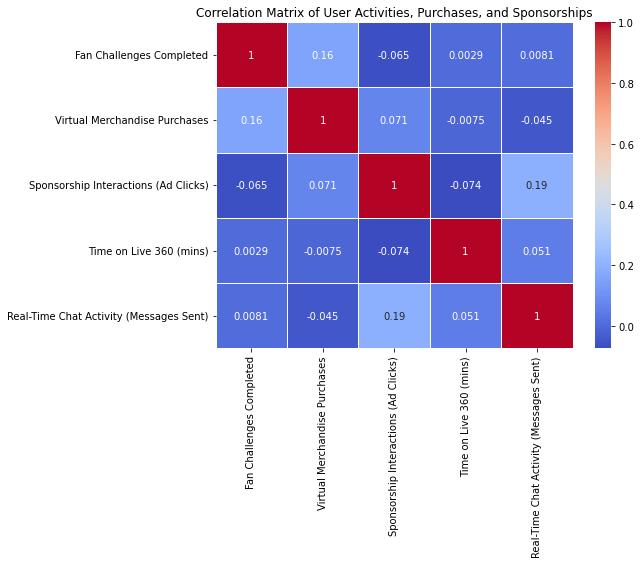

The strongest relationship is between 'Sponsorship Interactions (Ad Clicks)' and 'Real-Time Chat Activity (Messages Sent)' with a correlation of 0.19.

Additional insights from the correlation matrix:
 - 'Fan Challenges Completed' is strongly correlated with 'Virtual Merchandise Purchases' (Correlation: 0.159)
 - 'Virtual Merchandise Purchases' is strongly correlated with 'Sponsorship Interactions (Ad Clicks)' (Correlation: 0.071)
 - 'Fan Challenges Completed' is strongly correlated with 'Sponsorship Interactions (Ad Clicks)' (Correlation: -0.065)
 - 'Sponsorship Interactions (Ad Clicks)' is strongly correlated with 'Time on Live 360 (mins)' (Correlation: -0.074)


In [36]:
# ----------- Correlation Analysis: User Activities and Purchases/Sponsorships --------------
# Creating a correlation matrix to examine relationships between user activities
correlation_matrix = data[['Fan Challenges Completed', 'Virtual Merchandise Purchases', 
                           'Sponsorship Interactions (Ad Clicks)', 'Time on Live 360 (mins)', 
                           'Real-Time Chat Activity (Messages Sent)']].corr()

# Visualizing the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of User Activities, Purchases, and Sponsorships')
plt.show()

# Extract the highest correlations for meaningful insights
# Ignoring self-correlations (which are 1.0)
correlation_pairs = correlation_matrix.unstack().drop_duplicates()
correlation_pairs = correlation_pairs[correlation_pairs != 1].sort_values(ascending=False)

# Find the strongest relationships
highest_corr = correlation_pairs.idxmax()
highest_corr_value = correlation_pairs.max()

# Present meaningful insights based on the highest correlation
print(f"The strongest relationship is between '{highest_corr[0]}' and '{highest_corr[1]}' with a correlation of {highest_corr_value:.2f}.")

# Extracting more insights
print("\nAdditional insights from the correlation matrix:")
for i in range(len(correlation_pairs)-1):
    feature_pair = correlation_pairs.index[i+1]
    correlation_value = correlation_pairs.iloc[i+1]
    if abs(correlation_value) > 0.06:  # Highlight correlations with absolute value > 0.5
        print(f" - '{feature_pair[0]}' is strongly correlated with '{feature_pair[1]}' (Correlation: {correlation_value:.3f})")

/Users/yuhr/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



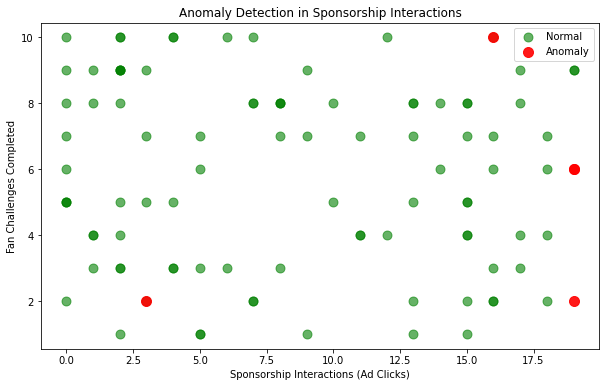

In [37]:
# ----------- Anomaly Detection on Sponsorship Interactions --------------
# Focusing on 'Sponsorship Interactions (Ad Clicks)' and related engagement metrics
sponsorship_interactions = data[['Sponsorship Interactions (Ad Clicks)', 
                                 'Fan Challenges Completed', 
                                 'Time on Live 360 (mins)', 
                                 'Real-Time Chat Activity (Messages Sent)']]

# Fit the Isolation Forest for anomaly detection
iso_forest_sponsor = IsolationForest(contamination=0.05, random_state=42)
data['Sponsorship Anomaly'] = iso_forest_sponsor.fit_predict(sponsorship_interactions)

# Anomalies are labeled as -1, normal points as 1
anomalies_sponsor = data[data['Sponsorship Anomaly'] == -1]
normal_points_sponsor = data[data['Sponsorship Anomaly'] == 1]

# ----------- Visualization: Anomalies in Sponsorship Interactions --------------
# Plot showing anomalies in red
plt.figure(figsize=(10, 6))
plt.scatter(normal_points_sponsor['Sponsorship Interactions (Ad Clicks)'], 
            normal_points_sponsor['Fan Challenges Completed'], 
            color='green', label='Normal', alpha=0.6, s=80)
plt.scatter(anomalies_sponsor['Sponsorship Interactions (Ad Clicks)'], 
            anomalies_sponsor['Fan Challenges Completed'], 
            color='red', label='Anomaly', alpha=0.9, s=100)
plt.title('Anomaly Detection in Sponsorship Interactions')
plt.xlabel('Sponsorship Interactions (Ad Clicks)')
plt.ylabel('Fan Challenges Completed')
plt.legend()
plt.show()

Merchandise Purchase Prediction Report (Random Forest):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        18

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



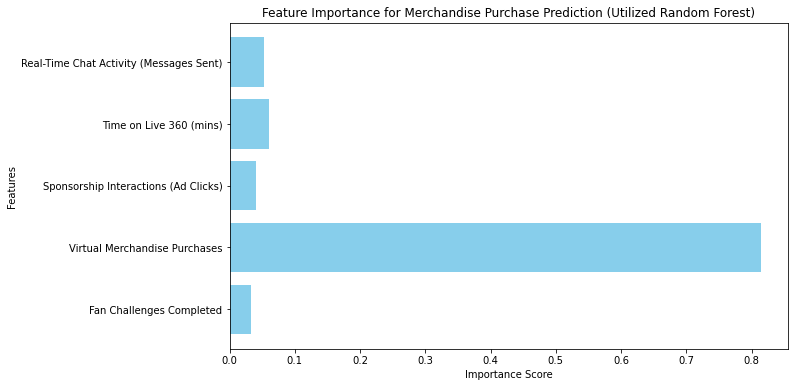

In [38]:
# ----------- Predictive Modeling for Merchandise Purchases --------------
# Define the target for merchandise purchase prediction (binary classification)
target_merch = (data['Virtual Merchandise Purchases'] > 0).astype(int)

# Define features for prediction
features_for_prediction = data[['Fan Challenges Completed', 
                                'Virtual Merchandise Purchases', 
                                'Sponsorship Interactions (Ad Clicks)', 
                                'Time on Live 360 (mins)', 
                                'Real-Time Chat Activity (Messages Sent)']]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_for_prediction, target_merch, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Display the classification report for Random Forest
rf_classification_report = classification_report(y_test, y_pred_rf)
print("Merchandise Purchase Prediction Report (Random Forest):\n", rf_classification_report)

# ----------- Feature Importance with Random Forest (without SHAP) --------------
# Extracting feature importances from the Random Forest model
importances = rf_model.feature_importances_
feature_names = features_for_prediction.columns

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.title('Feature Importance for Merchandise Purchase Prediction (Utilized Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


In [40]:
# ------------------- High-Value User Analysis ---------------------
# High-Value User Analysis
high_value_users = data[(data['Virtual Merchandise Purchases'] > data['Virtual Merchandise Purchases'].quantile(0.75)) &
                        (data['Sponsorship Interactions (Ad Clicks)'] > data['Sponsorship Interactions (Ad Clicks)'].quantile(0.75))]

# Dynamic Boxplot for High-Value Users
fig2 = go.Figure()
for feature in ['Fan Challenges Completed', 'Virtual Merchandise Purchases', 'Sponsorship Interactions (Ad Clicks)']:
    fig2.add_trace(go.Box(y=high_value_users[feature], name=feature))

fig2.update_layout(title_text='High-Value User Analysis Across Key Features', yaxis_title='Value')
fig2.show()

# Description for High-Value User Boxplot
print("### High-Value User Analysis Plot Description:")
print(f"This boxplot highlights the distribution of high-value users across key features like {', '.join(['Fan Challenges Completed', 'Virtual Merchandise Purchases', 'Sponsorship Interactions (Ad Clicks)'])}.")



### High-Value User Analysis Plot Description:
This boxplot highlights the distribution of high-value users across key features like Fan Challenges Completed, Virtual Merchandise Purchases, Sponsorship Interactions (Ad Clicks).


In [41]:
# ------------------- CLV Prediction ---------------------
data['CLV'] = data['Virtual Merchandise Purchases'] + data['Sponsorship Interactions (Ad Clicks)']
X_clv = features
y_clv = data['CLV']
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.2, random_state=42)

# Train Linear Regression for CLV
clv_model = LinearRegression()
clv_model.fit(X_train_clv, y_train_clv)
y_pred_clv = clv_model.predict(X_test_clv)

# CLV Prediction Visualization using Plotly
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=y_test_clv, y=y_pred_clv, mode='markers', marker=dict(color='blue', size=10, line=dict(width=1, color='white')), name='Predicted'))
fig3.add_trace(go.Scatter(x=[y_test_clv.min(), y_test_clv.max()], y=[y_test_clv.min(), y_test_clv.max()], mode='lines', line=dict(color='red', dash='dash'), name='Ideal Fit'))
fig3.update_layout(title='Customer Lifetime Value (CLV) Prediction: Actual vs Predicted', xaxis_title='Actual CLV', yaxis_title='Predicted CLV')
fig3.show()

# Description for CLV Prediction Plot
print(f"### CLV Prediction Plot Description:")
print("This scatter plot compares the actual vs. predicted Customer Lifetime Value (CLV). The red dashed line represents the ideal fit.")



### CLV Prediction Plot Description:
This scatter plot compares the actual vs. predicted Customer Lifetime Value (CLV). The red dashed line represents the ideal fit.


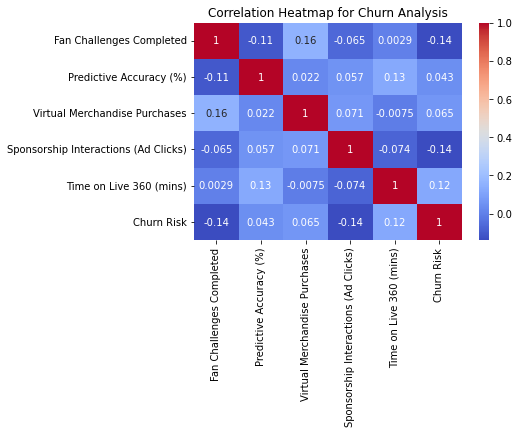

### Churn Risk Heatmap Description:
The most correlated feature with churn is Time on Live 360 (mins). This insight can be used to design retention strategies.


In [42]:
# ------------------- Churn Risk Analysis ---------------------
# Churn Analysis with Heatmap
data['Churn Risk'] = ((data['Fan Challenges Completed'] < data['Fan Challenges Completed'].quantile(0.25)) &
                      (data['Sponsorship Interactions (Ad Clicks)'] < data['Sponsorship Interactions (Ad Clicks)'].quantile(0.25))).astype(int)

churn_features = data[['Fan Challenges Completed', 'Predictive Accuracy (%)', 'Virtual Merchandise Purchases', 'Sponsorship Interactions (Ad Clicks)', 'Time on Live 360 (mins)', 'Churn Risk']]
sns.heatmap(churn_features.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Churn Analysis')
plt.show()

# Dynamic description for Churn Heatmap
most_correlated_feature = churn_features.corr()['Churn Risk'].sort_values(ascending=False).index[1]

print(f"### Churn Risk Heatmap Description:")
print(f"The most correlated feature with churn is {most_correlated_feature}. This insight can be used to design retention strategies.")

In [44]:
# ------------------- Merchandise Purchase Prediction ---------------------
merch_target = (data['Virtual Merchandise Purchases'] > 0).astype(int)
X_train_merch, X_test_merch, y_train_merch, y_test_merch = train_test_split(features, merch_target, test_size=0.2, random_state=42)

# Logistic Regression for Merchandise Prediction
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_merch, y_train_merch)
y_pred_merch = logreg.predict(X_test_merch)

# Classification Report for Merchandise Purchase Prediction
classification_rep = classification_report(y_test_merch, y_pred_merch)
print("Merchandise Purchase Prediction Report:\n")
print(classification_rep)

# Description for Merchandise Purchase Prediction Report
print(f"### Merchandise Purchase Prediction Report Description:")
print("This report shows the accuracy of predicting which users are likely to purchase virtual merchandise based on engagement metrics.")



Merchandise Purchase Prediction Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        18

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

### Merchandise Purchase Prediction Report Description:
This report shows the accuracy of predicting which users are likely to purchase virtual merchandise based on engagement metrics.


In [45]:
# ------------------- Correlation Plot for User Activities ---------------------
# Dynamic Scatter Plot for User Activities and Purchases
fig5 = px.scatter(data, x='Time on Live 360 (mins)', y='Virtual Merchandise Purchases', color='Sponsorship Interactions (Ad Clicks)',
                 title='User Activities vs. Merchandise Purchases and Sponsorship Interactions',
                 labels={'Time on Live 360 (mins)': 'Time on Live 360 (mins)', 'Virtual Merchandise Purchases': 'Virtual Merchandise Purchases'})
fig5.show()

# Dynamic description for User Activity Correlation Plot
print(f"### User Activity Correlation Plot Description:")
print("This scatter plot shows how user activities, such as time spent on Live 360, correlate with merchandise purchases and sponsorship interactions.")



### User Activity Correlation Plot Description:
This scatter plot shows how user activities, such as time spent on Live 360, correlate with merchandise purchases and sponsorship interactions.


In [46]:
# ------------------- Pie Chart for Time on Live 360 Categories ---------------------
# Segment users based on time spent on Live 360
bins = [0, 30, 60, 120, 180, data['Time on Live 360 (mins)'].max()]
labels = ['0-30 mins', '31-60 mins', '61-120 mins', '121-180 mins', '180+ mins']
data['Time on Live 360 Category'] = pd.cut(data['Time on Live 360 (mins)'], bins=bins, labels=labels)

# Group by Time Category
grouped_data = data.groupby('Time on Live 360 Category')['Virtual Merchandise Purchases'].sum().reset_index()

# Pie Chart for Merchandise Purchases by Time Spent
fig_pie = px.pie(grouped_data, values='Virtual Merchandise Purchases', names='Time on Live 360 Category', 
                 title='Distribution of Merchandise Purchases Based on Time Spent on Live 360',
                 labels={'Time on Live 360 Category': 'Time on Live 360 (mins)'})
fig_pie.show()

# Description for Pie Chart
print("### Merchandise Purchases Pie Chart Description:")
print("This pie chart shows the distribution of virtual merchandise purchases across different categories of time spent on Live 360.")

### Merchandise Purchases Pie Chart Description:
This pie chart shows the distribution of virtual merchandise purchases across different categories of time spent on Live 360.



Cluster 0:
 - Average Fan Challenges Completed: 5.19
 - Average Merchandise Purchases: 1.97
 - Average Sponsorship Interactions: 14.68
 - Average Time on Live 360: 133.74
 - Average Real-Time Chat Activity: 35.74

Cluster 1:
 - Average Fan Challenges Completed: 4.76
 - Average Merchandise Purchases: 1.08
 - Average Sponsorship Interactions: 4.40
 - Average Time on Live 360: 140.40
 - Average Real-Time Chat Activity: 17.80

Cluster 2:
 - Average Fan Challenges Completed: 6.67
 - Average Merchandise Purchases: 2.95
 - Average Sponsorship Interactions: 3.24
 - Average Time on Live 360: 113.10
 - Average Real-Time Chat Activity: 22.52

Cluster 3:
 - Average Fan Challenges Completed: 6.91
 - Average Merchandise Purchases: 5.09
 - Average Sponsorship Interactions: 10.22
 - Average Time on Live 360: 126.26
 - Average Real-Time Chat Activity: 20.83


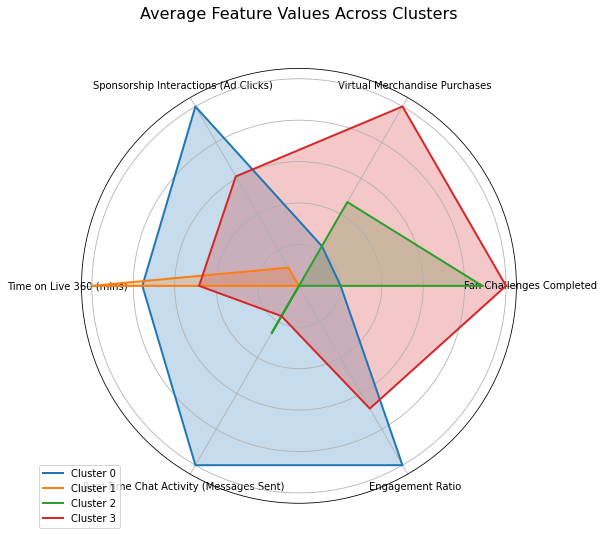

In [47]:
# Data for the radar chart

clustering_features = data[['Fan Challenges Completed', 'Predictive Accuracy (%)', 
                            'Virtual Merchandise Purchases', 'Sponsorship Interactions (Ad Clicks)', 
                            'Time on Live 360 (mins)', 'Real-Time Chat Activity (Messages Sent)']]

# Scale the features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Perform KMeans clustering on the entire dataset
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the original data
data['Cluster'] = clusters

# Calculate the average values for each feature per cluster
cluster_means = data.groupby('Cluster').mean()

# Features to plot
features = cluster_means.columns

# Number of clusters
num_clusters = cluster_means.shape[0]

def create_radar_chart(df, features):
    # Number of variables/features
    num_vars = len(features)

    # Compute angle for each feature on the radar chart (e.g., 6 features = 360/6 = 60 degrees apart)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Repeat the first angle to close the circle
    angles += angles[:1]

    # Initialize the radar chart
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot data for each cluster
    for idx in range(num_clusters):
        values = df.iloc[idx].tolist()  # Values for the current cluster
        values += values[:1]  # Repeat the first value to close the circle

        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {idx}')
        ax.fill(angles, values, alpha=0.25)

    # Add feature labels
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=10)

    # Add a title and legend
    plt.title("Average Feature Values Across Clusters", size=16, color="black", y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # Show the radar chart
    plt.show()


# Features to normalize (using all features, including Time on Live 360)
features_to_normalize = ['Fan Challenges Completed', 'Virtual Merchandise Purchases', 
                         'Sponsorship Interactions (Ad Clicks)', 'Time on Live 360 (mins)', 
                         'Real-Time Chat Activity (Messages Sent)', 'Engagement Ratio']

# Applying Min-Max Normalization
scaler = MinMaxScaler()
cluster_means_normalized = pd.DataFrame(scaler.fit_transform(cluster_means[features_to_normalize]), 
                                        columns=features_to_normalize, 
                                        index=cluster_means.index)

for cluster_num in cluster_means.index:
    print(f"\nCluster {cluster_num}:")
    print(f" - Average Fan Challenges Completed: {cluster_means.loc[cluster_num, 'Fan Challenges Completed']:.2f}")
    print(f" - Average Merchandise Purchases: {cluster_means.loc[cluster_num, 'Virtual Merchandise Purchases']:.2f}")
    print(f" - Average Sponsorship Interactions: {cluster_means.loc[cluster_num, 'Sponsorship Interactions (Ad Clicks)']:.2f}")
    print(f" - Average Time on Live 360: {cluster_means.loc[cluster_num, 'Time on Live 360 (mins)']:.2f}")
    print(f" - Average Real-Time Chat Activity: {cluster_means.loc[cluster_num, 'Real-Time Chat Activity (Messages Sent)']:.2f}")
    
# Plotting the normalized radar chart
create_radar_chart(cluster_means_normalized, features_to_normalize)
